## Categorization

Labels: -1, 0, 1 (0,1,2 for xgboost) based on y

- Standard deviation based with 0.2 multiplier
- based on 20th percentile
- fixed -0.1 to 0.1 for neutral label.

Target Return Statistics:
count    5746.000000
mean        0.005599
std         0.220234
min        -1.401949
25%        -0.106014
50%         0.015357
75%         0.129103
max         1.353311
Name: target, dtype: float64

Percentiles:
1th percentile: -0.582636
5th percentile: -0.361621
10th percentile: -0.259458
20th percentile: -0.143867
30th percentile: -0.076926
40th percentile: -0.025258
50th percentile: 0.015357
60th percentile: 0.054790
70th percentile: 0.102701
80th percentile: 0.158656
90th percentile: 0.252788
95th percentile: 0.346007
99th percentile: 0.524544


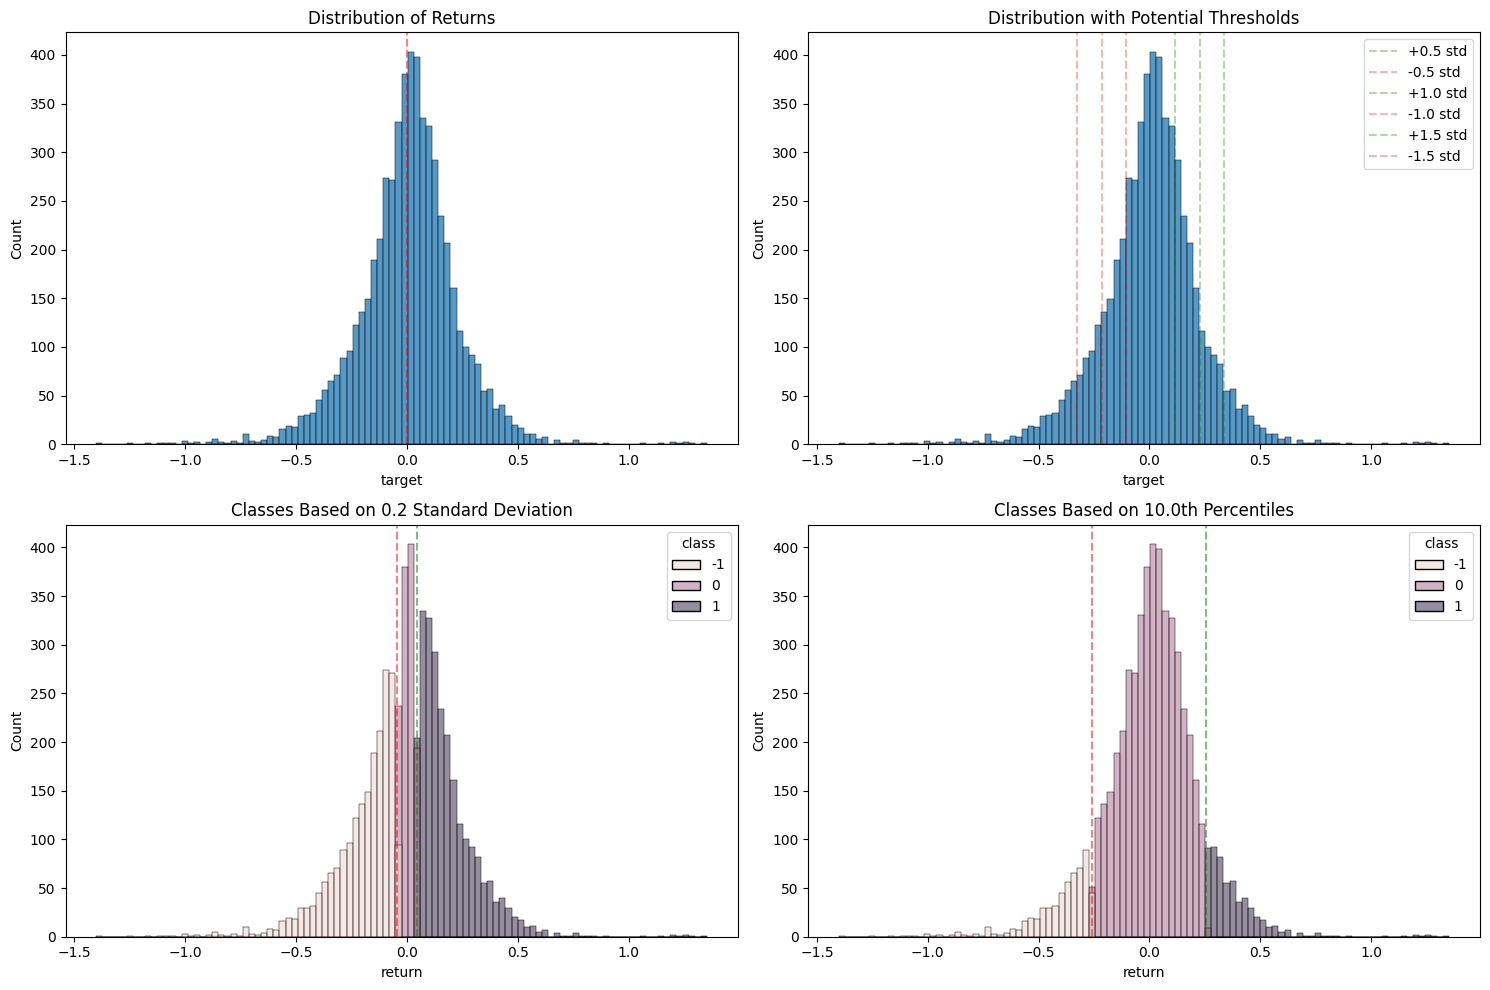


Class Distribution (STD-based):
 1    0.428124
-1    0.360599
 0    0.211277
Name: proportion, dtype: float64

Class Distribution (Percentile-based):
 0    0.799861
-1    0.100070
 1    0.100070
Name: proportion, dtype: float64

Mean Return by Class (STD-based):
class
-1   -0.208692
 0    0.001408
 1    0.188160
Name: return, dtype: float64

Mean Return by Class (Percentile-based):
class
-1   -0.411293
 0    0.010291
 1    0.384993
Name: return, dtype: float64


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('model_data.csv')

# Basic statistics of the target variable
print("Target Return Statistics:")
print(df['target'].describe())

# Calculate different percentiles
percentiles = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    print(f"{p}th percentile: {df['target'].quantile(p/100):.6f}")

# Plot distribution
plt.figure(figsize=(15, 10))

# Plot 1: Overall distribution
plt.subplot(2, 2, 1)
sns.histplot(df['target'], bins=100)
plt.title('Distribution of Returns')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)

# Plot 2: Distribution with potential thresholds
plt.subplot(2, 2, 2)
sns.histplot(df['target'], bins=100)
plt.title('Distribution with Potential Thresholds')

# Add lines for different standard deviations
std = df['target'].std()
mean = df['target'].mean()
for i in [0.5, 1.0, 1.5]:
    plt.axvline(x=mean + i*std, color='g', linestyle='--', alpha=0.3, label=f'+{i} std')
    plt.axvline(x=mean - i*std, color='r', linestyle='--', alpha=0.3, label=f'-{i} std')
plt.legend()

# Let's try different threshold approaches
# Approach 1: Standard deviation based
std_multiplier = 0.2
std_threshold = std_multiplier * std
labels_std = np.where(df['target'] > std_threshold, 1,
                     np.where(df['target'] < -std_threshold, -1, 0))

# Approach 2: Percentile based
percentile_threshold = 0.1  # top/bottom 20%
top_threshold = df['target'].quantile(1 - percentile_threshold)
bottom_threshold = df['target'].quantile(percentile_threshold)
labels_percentile = np.where(df['target'] > top_threshold, 1,
                           np.where(df['target'] < bottom_threshold, -1, 0))

# Plot 3: Distribution of STD-based classes
plt.subplot(2, 2, 3)
sns.histplot(data=pd.DataFrame({'return': df['target'], 'class': labels_std}), 
            x='return', hue='class', bins=100)
plt.title(f'Classes Based on {std_multiplier} Standard Deviation')
plt.axvline(x=std_threshold, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=-std_threshold, color='r', linestyle='--', alpha=0.5)

# Plot 4: Distribution of Percentile-based classes
plt.subplot(2, 2, 4)
sns.histplot(data=pd.DataFrame({'return': df['target'], 'class': labels_percentile}), 
            x='return', hue='class', bins=100)
plt.title(f'Classes Based on {percentile_threshold*100}th Percentiles')
plt.axvline(x=top_threshold, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=bottom_threshold, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print class distributions
print("\nClass Distribution (STD-based):")
print(pd.Series(labels_std).value_counts(normalize=True))

print("\nClass Distribution (Percentile-based):")
print(pd.Series(labels_percentile).value_counts(normalize=True))

# Calculate mean return for each class
print("\nMean Return by Class (STD-based):")
std_df = pd.DataFrame({'return': df['target'], 'class': labels_std})
print(std_df.groupby('class')['return'].mean())

print("\nMean Return by Class (Percentile-based):")
perc_df = pd.DataFrame({'return': df['target'], 'class': labels_percentile})
print(perc_df.groupby('class')['return'].mean())

### Transform Labels

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
import optuna

# Read and prepare the data
df = pd.read_csv('model_data.csv')
df = df.drop('Open time', axis=1)

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data first so we only use train data statistics for thresholds
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Calculate threshold based on training data only
# train_std = y_train.std()
# threshold = 0.3 * train_std

# MANUAL THRESHOLD 0.1 (meaning returns between -0.1 and 0.1 are 0)
#threshold = 0.1

# or 20th percentile
percentile_threshold = 0.1  # top/bottom 20%
top_threshold = y_train.quantile(1 - percentile_threshold)
bottom_threshold = y_train.quantile(percentile_threshold)
def create_labels(y, top_threshold, bottom_threshold):
    return np.where(y > top_threshold, 2,
                           np.where(y < bottom_threshold, 0, 1))

y_train_classes = create_labels(y_train, top_threshold, bottom_threshold)
y_test_classes = create_labels(y_test, top_threshold, bottom_threshold)

# Transform targets into classes (update this function) instead of -1,0,1 do 0,1,2
# def create_labels(y, threshold):
#     return np.where(y > threshold, 2,
#                    np.where(y < -threshold, 0, 1))

# y_train_classes = create_labels(y_train, threshold)
# y_test_classes = create_labels(y_test, threshold)

# Print class distribution
print("Training Class Distribution:")
print(pd.Series(y_train_classes).value_counts(normalize=True))
print("\nTest Class Distribution:")
print(pd.Series(y_test_classes).value_counts(normalize=True))



Training Class Distribution:
1    0.799826
0    0.100087
2    0.100087
Name: proportion, dtype: float64

Test Class Distribution:
1    0.897391
2    0.055652
0    0.046957
Name: proportion, dtype: float64


In [7]:
# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
def select_features(X_train_scaled, X_test_scaled, X, threshold=0.01):
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        num_class=3
    )
    model.fit(X_train_scaled, y_train_classes)
    
    selector = SelectFromModel(model, prefit=True, threshold=threshold)
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)
    
    selected_features = X.columns[selector.get_support()].tolist()
    print(f"Selected {len(selected_features)} features")
    
    return X_train_selected, X_test_selected, selected_features

# Optuna objective function
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
    }
    
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        num_class=3,
        **params
    )
    
    model.fit(
        X_train_selected,
        y_train_classes,
        eval_set=[(X_test_selected, y_test_classes)],
        early_stopping_rounds=20,
        verbose=False
    )
    
    preds = model.predict(X_test_selected)
    return accuracy_score(y_test_classes, preds)

# Perform feature selection
X_train_selected, X_test_selected, selected_features = select_features(X_train_scaled, X_test_scaled, X)

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

best_params = study.best_params
print("\nBest hyperparameters:", best_params)

# Train final model with best parameters
final_model = xgb.XGBClassifier(
    objective='multi:softprob',
    random_state=42,
    num_class=3,
    **best_params
)

# Train with early stopping
final_model.fit(
    X_train_selected,
    y_train_classes,
    eval_set=[(X_test_selected, y_test_classes)],
    early_stopping_rounds=20,
    verbose=False
)

# Make predictions
y_pred = final_model.predict(X_test_selected)
y_pred_proba = final_model.predict_proba(X_test_selected)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred))



[I 2024-11-06 08:11:34,676] A new study created in memory with name: no-name-3db9159d-b191-4b00-9b55-c52ce8f671ce


Selected 61 features


/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-11-06 08:11:36,429] Trial 0 finished with value: 0.8930434782608696 and parameters: {'learning_rate': 0.06959842917803154, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.627265297731206, 'colsample_bytree': 0.8448860847498032, 'gamma': 0.27957877188992986, 'n_estimators': 186, 'reg_alpha': 2.9459502458814478e-05, 'reg_lambda': 4.5696343125078575e-07}. Best is trial 0 with value: 0.8930434782608696.
/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set


Best hyperparameters: {'learning_rate': 0.0002697479714261067, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.7167316707171149, 'colsample_bytree': 0.7300982340231137, 'gamma': 5.0596626794062773e-05, 'n_estimators': 300, 'reg_alpha': 0.13425491599890926, 'reg_lambda': 0.07062310564359707}

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.90      1.00      0.95      1032
           2       0.00      0.00      0.00        64

    accuracy                           0.90      1150
   macro avg       0.30      0.33      0.32      1150
weighted avg       0.81      0.90      0.85      1150



/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

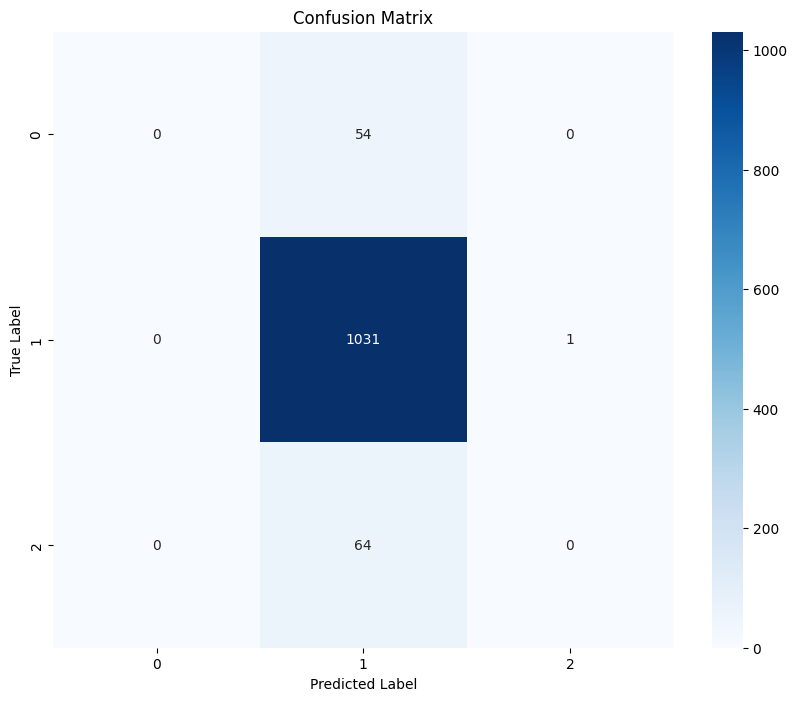

In [8]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



/var/folders/8p/dwqnp65s0s77jdbm4_6z4vp80000gn/T/ipykernel_28400/346670162.py:25: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = np.sqrt(252) * returns.mean() / returns.std()
/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/8p/dwqnp65s0s77jdbm4_6z4vp80000gn/T/ipykernel_28400/346670162.py:25: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = np.sqrt(252) * returns.mean() / returns.std()
/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)



Performance at different confidence thresholds:
   confidence_threshold  sharpe  accuracy  coverage
0                   0.4     NaN       NaN       0.0
1                   0.5     NaN       NaN       0.0
2                   0.6     NaN       NaN       0.0
3                   0.7     NaN       NaN       0.0
4                   0.8     NaN       NaN       0.0


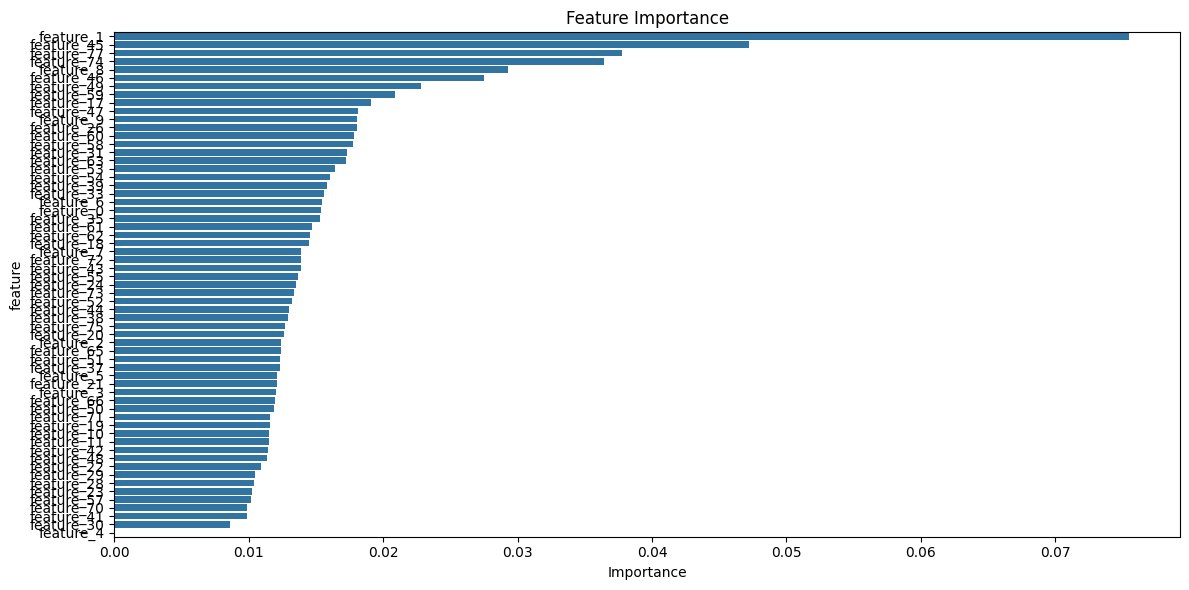

In [9]:
# Calculate returns based on predictions
def calculate_returns(predictions, actual_returns, confidence_threshold=0.0):
    pred_probs = final_model.predict_proba(X_test_selected)
    max_probs = np.max(pred_probs, axis=1)
    
    # Only take positions when confidence exceeds threshold
    positions = np.zeros_like(predictions, dtype=float)
    confident_mask = max_probs > confidence_threshold
    
    # Convert predictions 0->-1, 2->1 for returns calculation
    adj_predictions = np.where(predictions == 2, 1, np.where(predictions == 0, -1, 0))
    positions[confident_mask] = adj_predictions[confident_mask]
    
    returns = positions * actual_returns
    return returns, np.mean(confident_mask)

# Test different confidence thresholds
confidence_thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
results = []

for conf_threshold in confidence_thresholds:
    returns, coverage = calculate_returns(y_pred, y_test.values, conf_threshold)
    
    # Calculate metrics
    sharpe = np.sqrt(252) * returns.mean() / returns.std()
    accuracy = accuracy_score(y_test_classes[returns != 0], 
                            y_pred[returns != 0])
    
    results.append({
        'confidence_threshold': conf_threshold,
        'sharpe': sharpe,
        'accuracy': accuracy,
        'coverage': coverage
    })

results_df = pd.DataFrame(results)
print("\nPerformance at different confidence thresholds:")
print(results_df)

# Plot feature importance
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': final_model.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()



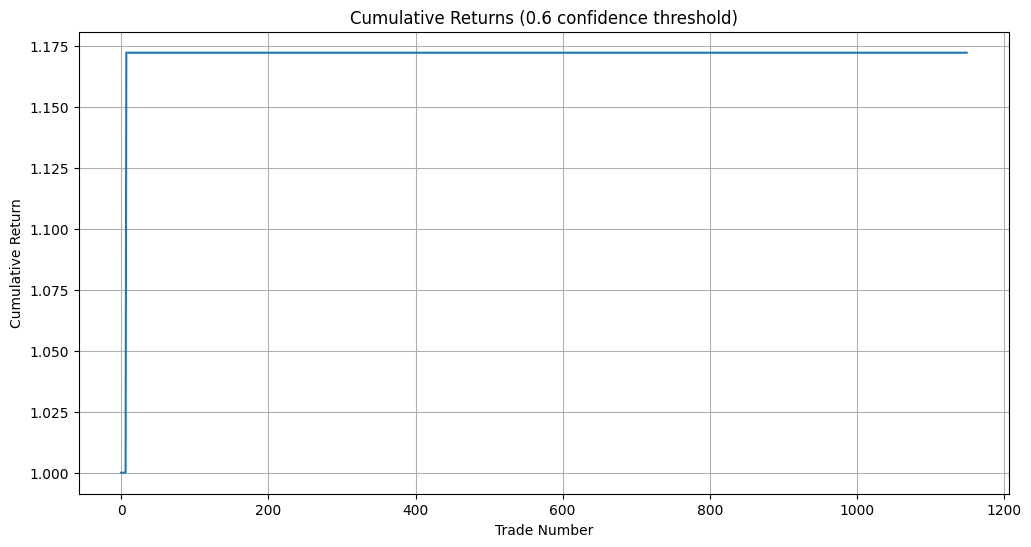

In [12]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
returns, _ = calculate_returns(y_pred, y_test.values, 0.2)  # Using 0.6 confidence threshold
cumulative_returns = (1 + returns).cumprod()
plt.plot(cumulative_returns)
plt.title('Cumulative Returns (0.6 confidence threshold)')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()



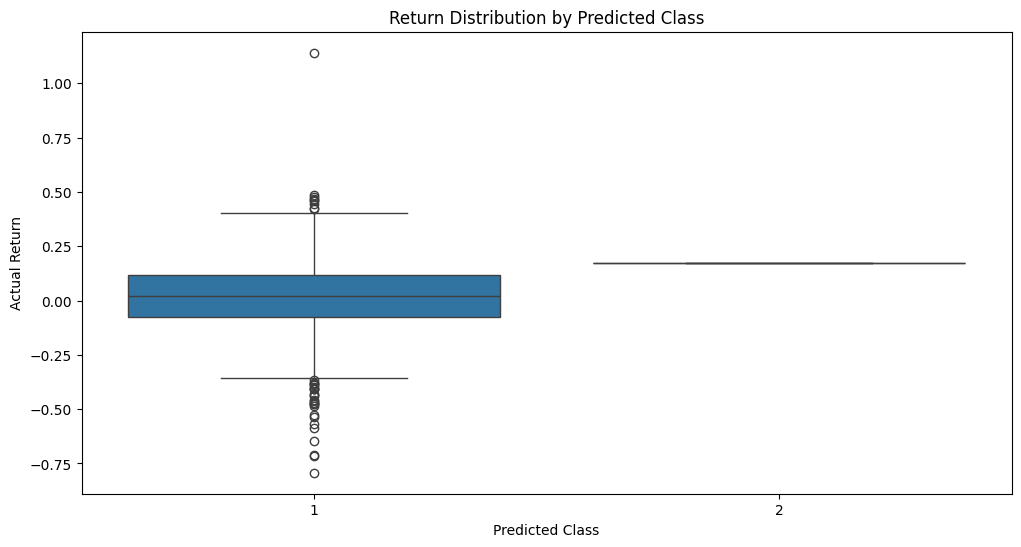

In [13]:
# Plot return distribution by predicted class
plt.figure(figsize=(12, 6))
sns.boxplot(x=y_pred, y=y_test.values)
plt.title('Return Distribution by Predicted Class')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Return')
plt.show()

In [64]:
# Save just the XGBoost model
final_model.save_model('xgb_model.json')  # or .bin format

# Load just the XGBoost model
# loaded_xgb = xgb.XGBClassifier()
# loaded_xgb.load_model('xgb_model.json')

## Another approach with additional features

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read and prepare the data
df = pd.read_csv('model_data.csv')
ts_events = df['Open time'].copy()  # Save timestamps before dropping
df = df.drop('Open time', axis=1)

new_colums = []

# Feature engineering with proper time shifting
for feat in df.columns:
    if feat != 'target':
        try:
            # All rolling features need to be shifted by 1 to avoid lookahead
            new_colums.append(df[feat].rolling(20, min_periods=1).mean().shift(1).rename(f'{feat}_roll_mean_20'))
            new_colums.append(df[feat].rolling(20, min_periods=1).std().shift(1).rename(f'{feat}_roll_std_20'))
            new_colums.append(df[feat].rolling(5, min_periods=1).mean().shift(1).rename(f'{feat}_roll_mean_5'))
            new_colums.append(df[feat].rolling(5, min_periods=1).std().shift(1).rename(f'{feat}_roll_std_5'))
        except Exception as e:
            print(f"Error creating rolling features for {feat}: {str(e)}")

# Target-based features should also only use past data target_roll_mean_20
try:
    new_colums.append(df['target'].rolling(20, min_periods=1).mean().shift(1).rename('target_roll_mean_20'))
    new_colums.append(df['target'].rolling(20, min_periods=1).std().shift(1).rename('target_roll_std_20'))
    new_colums.append((df['target'] - df['target_roll_mean_20']) / df['target_roll_std_20'].replace(0, np.nan).rename('target_zscore_20'))
except Exception as e:
    print(f"Error creating target features: {str(e)}")

# Add time-based features
try:
    df_times = pd.to_datetime(ts_events)
    new_colums.append(df_times.dt.hour.rename('hour'))
    new_colums.append(df_times.dt.minute.rename('minute'))
    new_colums.append(df_times.dt.dayofweek.rename('day_of_week'))
except Exception as e:
    print(f"Error creating time features: {str(e)}")

# Concatenate new columns at once bc of defragmentation
df = pd.concat([df] + new_colums, axis=1)

# # Fill any NaN values with forward fill then backward fill
# df = df.fillna(method='ffill').fillna(method='bfill')

# Split the data respecting time order
train_size = int(len(df) * 0.8)
df_train = df[:train_size]
df_test = df[train_size:]

# Calculate threshold based on training data only
train_std = df_train['target'].std()
threshold = 0.2 * train_std

# threshold = 0.1 #fixed threshold -threshodl to threshold is label 1

def create_labels(y, threshold):
    return np.where(y > threshold, 2,
                   np.where(y < -threshold, 0, 1))

# Separate features and target
feature_cols = [col for col in df.columns if col != 'target']
X_train = df_train[feature_cols]
X_test = df_test[feature_cols]
y_train = create_labels(df_train['target'].values, threshold)
y_test = create_labels(df_test['target'].values, threshold)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Class distribution in training set:", np.bincount(y_train))
print("Class distribution in test set:", np.bincount(y_test))

# FIT scaler only on training data
X_train, X_test = X[:train_size], X[train_size:]
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to proper format for XGBoost
X_train_scaled = np.asarray(X_train_scaled)
X_test_scaled = np.asarray(X_test_scaled)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("\nBest hyperparameters:", best_params)

# Train final model with best parameters
final_model = xgb.XGBClassifier(
    objective='multi:softprob',
    random_state=42,
    num_class=3,
    **best_params
)

# Train with early stopping
final_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    early_stopping_rounds=20,
    verbose=False
)

# Make predictions
y_pred = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Alternatively use CV with TimeSeriesSplit

In [ ]:
# Replace the current validation split with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store performance metrics
cv_scores = []
cv_models = []

# Train a model for each fold
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
    # Split data for this fold
    X_cv_train = X_train_scaled[train_idx]
    y_cv_train = y_train[train_idx]
    X_cv_val = X_train_scaled[val_idx]
    y_cv_val = y_train[val_idx]
    
    # Initialize and train model
    fold_model = xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        num_class=3,
        max_depth=3,
        learning_rate=0.01,
        n_estimators=1000,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        gamma=1,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    
    # Train model
    fold_model.fit(
        X_cv_train, 
        y_cv_train,
        eval_set=[(X_cv_val, y_cv_val)],
        early_stopping_rounds=50,
        verbose=100
    )
    
    # Make predictions on validation set
    y_pred = fold_model.predict(X_cv_val)
    
    # Calculate and store score
    score = accuracy_score(y_cv_val, y_pred)
    cv_scores.append(score)
    cv_models.append(fold_model)
    
    print(f"Fold {fold + 1} accuracy: {score:.4f}")

print(f"\nMean CV accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# Use the best model or average predictions from all models
best_model = cv_models[np.argmax(cv_scores)]
# Or use the last model trained on the most recent data
final_model = cv_models[-1]

model = final_model

### Alternative with optuna feature selection

In [ ]:
# Feature selection
def select_features(X_train_scaled, X_test_scaled, X, threshold=0.01):
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        num_class=3
    )
    model.fit(X_train_scaled, y_train_classes)
    
    selector = SelectFromModel(model, prefit=True, threshold=threshold)
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)
    
    selected_features = X.columns[selector.get_support()].tolist()
    print(f"Selected {len(selected_features)} features")
    
    return X_train_selected, X_test_selected, selected_features

# Optuna objective function
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
    }
    
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        num_class=3,
        **params
    )
    
    model.fit(
        X_train_selected,
        y_train_classes,
        eval_set=[(X_test_selected, y_test_classes)],
        early_stopping_rounds=20,
        verbose=False
    )
    
    preds = model.predict(X_test_selected)
    return accuracy_score(y_test_classes, preds)

# Perform feature selection
X_train_selected, X_test_selected, selected_features = select_features(X_train_scaled, X_test_scaled, X)

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
print("\nBest hyperparameters:", best_params)

# Train final model with best parameters
final_model = xgb.XGBClassifier(
    objective='multi:softprob',
    random_state=42,
    num_class=3,
    **best_params
)

# Train with early stopping
final_model.fit(
    X_train_selected,
    y_train_classes,
    eval_set=[(X_test_selected, y_test_classes)],
    early_stopping_rounds=20,
    verbose=False
)

# Make predictions
y_pred = final_model.predict(X_test_selected)
y_pred_proba = final_model.predict_proba(X_test_selected)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred))


In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Continue

In [ ]:
def predict_with_confidence(model, X, confidence_threshold=0.6):
    try:
        probas = model.predict_proba(X)
        max_probas = np.max(probas, axis=1)
        preds = model.predict(X)
        preds = np.where(max_probas >= confidence_threshold, preds, 1)  # neutral class
        return preds, max_probas
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        return None, None

# Evaluate with different confidence thresholds
confidence_thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
results = []

for conf_thresh in confidence_thresholds:
    try:
        y_pred, conf_scores = predict_with_confidence(model, X_test_scaled, conf_thresh)
        
        if y_pred is not None:
            acc = accuracy_score(y_test, y_pred)
            pred_returns = np.where(y_pred == 2, 1, np.where(y_pred == 0, -1, 0))
            actual_returns = df_test['target'].values
            strategy_returns = pred_returns * actual_returns
            
            sharpe = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()
            coverage = np.mean(y_pred != 1)
            
            results.append({
                'confidence_threshold': conf_thresh,
                'accuracy': acc,
                'sharpe': sharpe,
                'coverage': coverage,
                'mean_return': strategy_returns.mean(),
                'total_return': (1 + strategy_returns).prod() - 1
            })
    except Exception as e:
        print(f"Error evaluating threshold {conf_thresh}: {str(e)}")

if results:
    results_df = pd.DataFrame(results)
    print("\nPerformance at different confidence thresholds:")
    print(results_df)
    
    # Plot cumulative returns for best threshold
    try:
        best_thresh = results_df.loc[results_df['sharpe'].idxmax(), 'confidence_threshold']
        y_pred_best, _ = predict_with_confidence(model, X_test_scaled, best_thresh)
        
        if y_pred_best is not None:
            pred_returns = np.where(y_pred_best == 2, 1, np.where(y_pred_best == 0, -1, 0))
            strategy_returns = pred_returns * df_test['target'].values
            cum_returns = (1 + strategy_returns).cumprod()

            plt.figure(figsize=(12, 6))
            plt.plot(cum_returns)
            plt.title(f'Cumulative Returns (Confidence Threshold = {best_thresh})')
            plt.xlabel('Trade Number')
            plt.ylabel('Cumulative Return')
            plt.grid(True)
            plt.show()
    except Exception as e:
        print(f"Error plotting results: {str(e)}")

In [ ]:
# Confusion matrix for best confidence threshold
y_pred_best, _ = predict_with_confidence(model, X_test_scaled, best_thresh)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Confidence Threshold = {best_thresh})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report too
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

In [ ]:
# Plot return distribution by predicted class
plt.figure(figsize=(12, 6))
predicted_returns_df = pd.DataFrame({
   'Predicted_Class': y_pred_best,
   'Actual_Return': df_test['target'].values
})
sns.boxplot(x='Predicted_Class', y='Actual_Return', data=predicted_returns_df)
plt.title('Return Distribution by Predicted Class')
plt.xlabel('Predicted Class (0: Short, 1: Neutral, 2: Long)')
plt.ylabel('Actual Return')
plt.show()

In [ ]:
# Plot feature importance
feature_importance = pd.DataFrame({
   'feature': X_train.columns,
   'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(20)  # top 20 features

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Print actual values
print("\nTop 20 features importance values:")
print(feature_importance)

In [26]:
# Save just the XGBoost model
model.save_model('xgb_model_approach2.json')  # or .bin format

# Load just the XGBoost model
# loaded_xgb = xgb.XGBClassifier()
# loaded_xgb.load_model('xgb_model.json')